# Mobile Game A/B Testing

I will run do an A/B testing analysis on the cookie cats dataset.  The dataset can be found on Kaggle.<br>
Basically we would like to find out if there is a difference in user behavior when we place a gate at level 30 and at level 40<br>
The data contains a control group at gate 30 and a test group at gate 40.<br>
The user's behavior can be determined by number of games place, and also 1Day/7Day retention status

In [851]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from ml_data import utils
from scipy.stats import shapiro
import scipy.stats as stats
sns.set_palette("pastel")
from IPython.display import display

### Load dataset

In [852]:
df = pd.read_csv('data/cookie_cats.csv')

### Display the usual data about this dataset

In [853]:
display(df.head())

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [854]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


None

In [855]:
display(df.columns)

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

In [856]:
display(df.nunique())

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64

In [857]:
display(df.describe())

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


**we have a outlier value of 49854**

### Check for null values

In [858]:
assert df.isnull().values.sum() == 0, 'error null values'
display('no null value')

'no null value'

### The range of values in different percentiles

In [859]:
display(df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]])

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
1%,0.000000
5%,1.000000
10%,1.000000
20%,3.000000
50%,16.000000
80%,67.000000


**50% of the people played less than 16 games**

Clip data so that outlier points become boundary values<br>
df['sum_gamerounds'] = df['sum_gamerounds'].clip(lower=df['sum_gamerounds'].quantile(0.01), upper=df['sum_gamerounds'].quantile(0.99), axis=0)<br>
display(df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]])

#### Remove the outlier in data<br>
49854 games played in the first 7 days is unlikely a normal behavior of a normal user

In [860]:
df = df[df['sum_gamerounds'] < df['sum_gamerounds'].max()]

### Summary stats about the A/B groups

In [861]:
summary_stats = df.groupby("version")['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])
display(summary_stats)

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


### Distribution of game rounds values for the 2 groups

we plot values within the 99% percentile

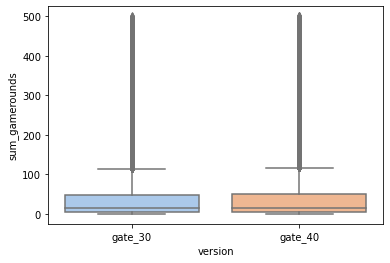

In [862]:
sns.boxplot(x=df['version'], y=df[df['sum_gamerounds'] <= 500]['sum_gamerounds'])
plt.show()

### Histograms for gate 30 and gate 40

<AxesSubplot:title={'center':'Gate 40'}, ylabel='Frequency'>

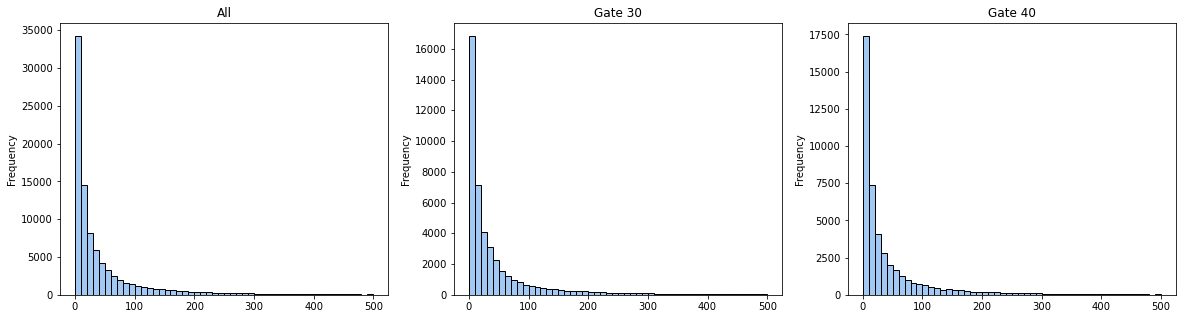

In [863]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
df.query('sum_gamerounds <= 500')['sum_gamerounds'].plot.hist(title='All', histtype='bar', bins=50, ec='black', ax=axes[0])
df.query('version == "gate_30" & sum_gamerounds <= 500')['sum_gamerounds'].plot.hist(title='Gate 30', histtype='bar', bins=50, ec='black', ax=axes[1])
df.query('version == "gate_40" & sum_gamerounds <= 500')['sum_gamerounds'].plot.hist(title='Gate 40', histtype='bar', bins=50, ec='black', ax=axes[2])

### 1D retention for gate 30 and gate 40

<AxesSubplot:title={'center':'1D Gate 40'}, ylabel='Frequency'>

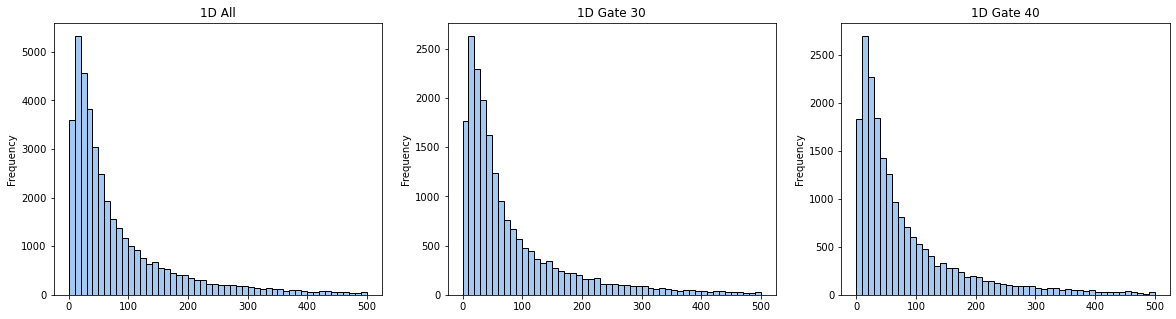

In [864]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
df.query('retention_1 == True & sum_gamerounds <= 500')['sum_gamerounds'].plot.hist(title='1D All', histtype='bar', bins=50, ec='black', ax=axes[0])
df.query('retention_1 == True & version == "gate_30" & sum_gamerounds <= 500')['sum_gamerounds'].plot.hist(title='1D Gate 30', histtype='bar', bins=50, ec='black', ax=axes[1])
df.query('retention_1 == True & version == "gate_40" & sum_gamerounds <= 500')['sum_gamerounds'].plot.hist(title='1D Gate 40', histtype='bar', bins=50, ec='black', ax=axes[2])

### 7D retention for gate 30 and gate 40

<AxesSubplot:title={'center':'7D Gate 40'}, ylabel='Frequency'>

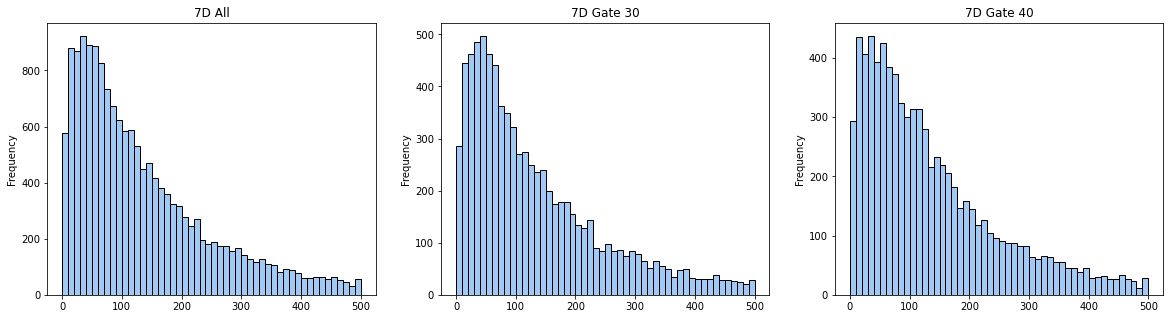

In [865]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
df.query('retention_7 == True & sum_gamerounds <= 500')['sum_gamerounds'].plot.hist(title='7D All', histtype='bar', bins=50, ec='black', ax=axes[0])
df.query('retention_7 == True & version == "gate_30" & sum_gamerounds <= 500')['sum_gamerounds'].plot.hist(title='7D Gate 30', histtype='bar', bins=50, ec='black', ax=axes[1])
df.query('retention_7 == True & version == "gate_40" & sum_gamerounds <= 500')['sum_gamerounds'].plot.hist(title='7D Gate 40', histtype='bar', bins=50, ec='black', ax=axes[2])

### Plot User / Gamerounds value chart for the 2 groups

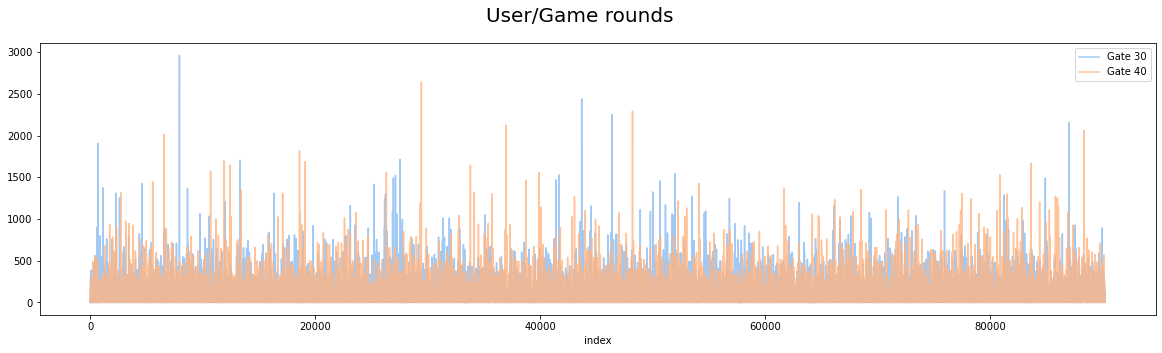

In [866]:
df[df['version']=='gate_30'].reset_index().set_index('index')['sum_gamerounds'].plot(legend=True, label='Gate 30', figsize=(20, 5))
df[df['version']=='gate_40'].reset_index().set_index('index')['sum_gamerounds'].plot(legend=True, label='Gate 40', alpha=0.8)
plt.suptitle("User/Game rounds", fontsize=20)
plt.show()

### Transformation of retention data

retention_1 and retention_7 columns contain True or False values, we can transform the data into a value counts table

In [867]:
df_retention = pd.DataFrame({'ret_1_count': df['retention_1'].value_counts(),
                             'ret_7_count': df['retention_7'].value_counts(),
                             'ret_1_ratio': df['retention_1'].value_counts() / len(df),
                             'ret_7_ratio': df['retention_7'].value_counts() / len(df),
                             })
display(df_retention)

,ret_1_count,ret_7_count,ret_1_ratio,ret_7_ratio
False,50035,73408,0.554786,0.813944
True,40153,16780,0.445214,0.186056


**1D retention rate is about 44%, 7D retention rate is about 18%**

### Group the games played by user, count the rank the result

,userid
sum_gamerounds,
0,3994
1,5538
2,4606
3,3958
4,3629
5,2992
6,2861
7,2379
8,2267


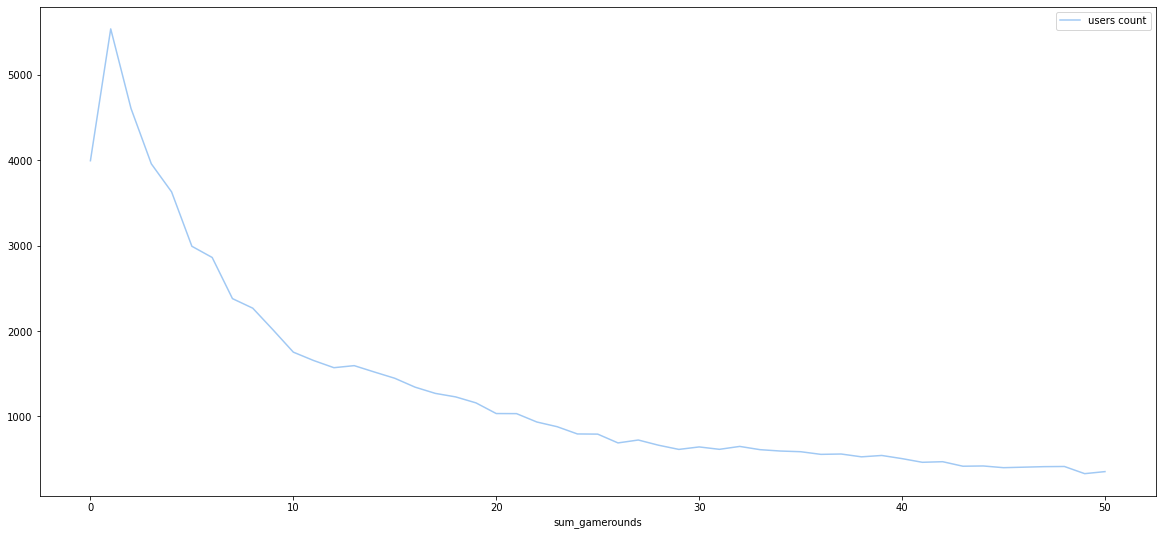

In [868]:
games_user_count = df.groupby("sum_gamerounds").userid.count().to_frame()
display(games_user_count.head(20))
games_user_count.loc[0:50]['userid'].plot(legend=True, label='users count', figsize=(20, 9))
plt.show()

### Number of people who did not open and play any game

In [869]:
no_play = df.query('sum_gamerounds == 0')
display(no_play.head())
display(len(no_play))

,userid,version,sum_gamerounds,retention_1,retention_7
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
26,3095,gate_30,0,False,False
35,4076,gate_40,0,False,False
37,4176,gate_30,0,False,False


3994

### Number of people who have played 30 to 40 games

In [870]:
gated = df.groupby("sum_gamerounds").userid.count().loc[[30, 40]]
display(gated)

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

### Summary statistics for the control and test group

In [871]:
summary_stats = df.groupby("version")['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])
display(summary_stats)

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


# Compare by retention days

## Compare 1D retention data for the 2 groups

In [872]:
ret_1d_stat = df.groupby(["version", "retention_1"])['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])
display(ret_1d_stat)

count  median       mean         std   max
version retention_1                                            
gate_30 False        24665     6.0  16.359092   36.528426  1072
        True         20034    48.0  94.411700  135.037697  2961
gate_40 False        25370     6.0  16.340402   35.925756  1241
        True         20119    49.0  95.381182  137.887256  2640

In [873]:
ret_1d = df.groupby("version")['retention_1'].mean()
display(ret_1d)

version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

**the 2 retention rate are very close**

## Compare at 7D retention data for the 2 groups

In [874]:
ret_7d_stat = df.groupby(["version", "retention_7"])['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])
display(ret_7d_stat)

count  median        mean         std   max
version retention_7                                             
gate_30 False        36198    11.0   25.796508   43.316158   981
        True          8501   105.0  160.117516  179.358560  2961
gate_40 False        37210    11.0   25.856356   44.406112  2640
        True          8279   111.0  165.649837  183.792499  2294

In [875]:
ret_7d = df.groupby("version")['retention_7'].mean()
display(ret_7d)

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

### Combine 1D and 7D retention data we can create a new categorical variable

In [876]:
df["RetentionStatus"] = list(map(lambda x, y: str(x)+"-"+str(y), df['retention_1'], df['retention_7']))
retention_status = df.groupby(["version", "RetentionStatus"])['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])
display(retention_status)

count  median        mean         std   max
version RetentionStatus                                             
gate_30 False-False      22840     6.0   11.819746   21.642643   981
        False-True        1825    43.0   73.169315   93.222330  1072
        True-False       13358    33.0   49.694490   58.125396   918
        True-True         6676   127.0  183.886309  189.626390  2961
gate_40 False-False      23597     6.0   11.913294   20.901020   547
        False-True        1773    47.0   75.261139   94.478048  1241
        True-False       13613    32.0   50.025490   60.924587  2640
        True-True         6506   133.0  190.282355  194.220077  2294

**we can see that for each grouping the summary stats are similar for gate 30 and 40**<br>
**next we need to do some tests to see if they are significantly not similar**

# Test for normality

In [877]:
df = pd.read_csv('data/cookie_cats.csv')
df = df[df['sum_gamerounds'] < df['sum_gamerounds'].max()]

In [878]:
group_a = df[df['version'] == 'gate_30']['sum_gamerounds']
group_b = df[df['version'] == 'gate_40']['sum_gamerounds']
display(group_a)
display(group_b)

0         3
1        38
6         0
11        0
13       39
         ..
90179    14
90180     7
90182    21
90183    10
90186    28
Name: sum_gamerounds, Length: 44699, dtype: int64

2        165
3          1
4        179
5        187
7          2
        ... 
90181     10
90184     97
90185     30
90187     51
90188     16
Name: sum_gamerounds, Length: 45489, dtype: int64

In [879]:
shapiro_a = shapiro(group_a)
shapiro_b = shapiro(group_b)
if shapiro_a[1] < 0.05:
    display('group a is not normal')
else:
    display('group a is normal')
if shapiro_b[1] < 0.05:
    display('group b is not normal')
else:
    display('group b is normal')

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'group a is not normal'

'group b is not normal'

**the 2 groups are not normal**

### Run Mann-Whitney U Test

In [880]:
utest = stats.mannwhitneyu(group_a, group_b)
display(utest)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

# Test by bootstrapping

## Bootstrap 1D retention

### Creating an list with bootstrapped means for each gate group

In [881]:
sample_means = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    sample_means.append(boot_mean)

### plot kernel density of the bootstrap distributions

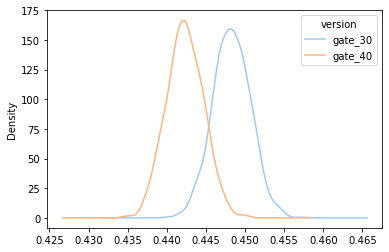

In [882]:
sample_means = pd.DataFrame(sample_means)
sample_means.plot(kind='density')
plt.show()

### calculate difference of the means of gate 30 and gate 40

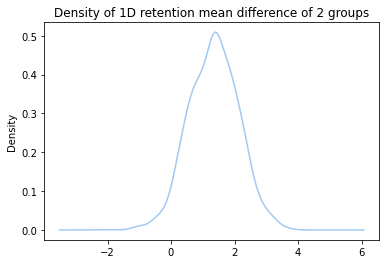

'For 1D retention, gate 30 mean is larger around 96.39999999999999% of the time'

In [883]:
sample_means['diff'] = (sample_means['gate_30'] - sample_means['gate_40']) / sample_means['gate_40'] * 100
ax = sample_means['diff'].plot(kind='density')
ax.set_title('Density of 1D retention mean difference of 2 groups')
plt.show()
ratio = (sample_means['diff'] > 0).mean() * 100
display(f'For 1D retention, gate 30 mean is larger around {ratio}% of the time')

## Bootstrap 7D retention

### Creating an list with bootstrapped means for each gate group

In [884]:
sample_means = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    sample_means.append(boot_mean)

### plot kernel density of the bootstrap distributions

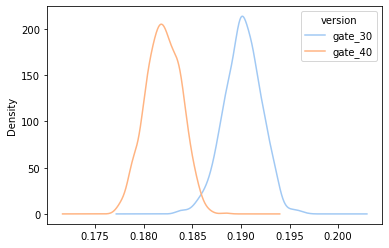

In [885]:
sample_means = pd.DataFrame(sample_means)
sample_means.plot(kind='density')
plt.show()

### calculate difference of the means of gate 30 and gate 40

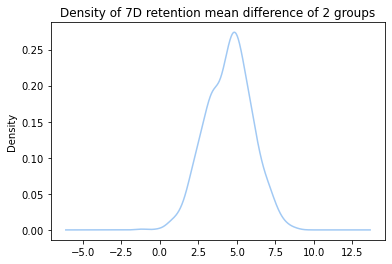

'For 7D retention, gate 30 mean is larger around 99.8% of the time'

In [886]:
sample_means['diff'] = (sample_means['gate_30'] - sample_means['gate_40']) / sample_means['gate_40'] * 100
ax = sample_means['diff'].plot(kind='density')
ax.set_title('Density of 7D retention mean difference of 2 groups')
plt.show()
ratio = (sample_means['diff'] > 0).mean() * 100
display(f'For 7D retention, gate 30 mean is larger around {ratio}% of the time')

# Conclusion

**From the Mann-Whitney U test result, the p-value is around 0.05**<br>
**we can say the distributions for the 2 groups are different, but it is hard to say how different these groups are**

**We then perform the bootstrap method to sample the data**<br>
**From the bootstrap test result above, in terms of retention rate**<br>
**placing the gate at level 30 will yield higher 1D retention and 7D retention and is therefore the better strategy**